<a href="https://colab.research.google.com/github/kdemertzis/EKPA/blob/main/Lambda_IDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
#εγκατάσταση πακέτου tensorflow (https://www.tensorflow.org/)
!pip install tensorflow
#εγκατάσταση πακέτου scikit-learn (https://scikit-learn.org/)
!pip install scikit-learn

In [52]:
#εισαγωγή βιβλιοθηκών - πακέτων
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, LSTM

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


In [53]:
nclass = 12
epochs = 5

In [54]:
#συνάρτηση εισαγωγής συνόλου δεδομένων
def load_dataset(file_path):
    df = pd.read_csv(file_path)
    X = df.drop('target', axis=1).values
    y = df['target'].values
    return X, y

In [55]:
#επιλογή αρχιτεκτονικής Dense, Conv1D, LSTM
architecture_choice='Conv1D'

In [56]:
#συνάρτηση δημιουργίας και εκπαίδευσης νευρωνικού δικτύου για multi-class
def create_and_train_model(input_dim, nclass, architecture_choice):
    model = Sequential()

    #επιλογή μεταξύ μοντέλων αρχιτεκτονικής
    if  architecture_choice == 'Dense':
            model.add(Dense(256, input_dim=input_dim, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Dense(128, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Dense(64, activation='relu'))
    elif architecture_choice == 'Conv1D':
            model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(input_dim,1)))
            model.add(Flatten())
            model.add(Dense(128, activation='relu'))
            model.add(Dropout(0.5))
    elif architecture_choice == 'LSTM':
            model.add(LSTM(64, input_shape=(input_dim,1)))
            model.add(Dense(128, activation='relu'))
    model.add(Dense(nclass, activation='softmax')) #multi-class output
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [57]:
#συνάρτηση αξιολόγησης μοντέλου και εκτύπωσης αποτελέσματων κατηγοριοποίησης
def evaluate_model(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    accuracy = classification_report(y_test, y_pred, output_dict=True)
    return accuracy['accuracy']

In [58]:
#συνάρτηση προσομοίωσης "λ" αρχιτεκτονικής για multi-class
def simulate_streaming_lambda_architecture(csv_file_path, model, scaler, architecture_choice, batch_size=500, retrain_every_batches=800, total_batches=8000):
    batch_counter = 0
    train_accuracies = []
    test_accuracies = []

    #φόρτωση συνόλου δεδομένων από csv αρχείο
    X_full, y_full = load_dataset(csv_file_path)
    #y_full_categorical = to_categorical(y_full, nclass)

    #τυποποίηση (standardize) δεδομένων
    X_full = scaler.transform(X_full)

    while batch_counter < total_batches:
        #κατάτμηση δεδομένων σε ροές (batches)
        for i in range(0, len(y_full), batch_size):
            batch_counter += 1
            X_batch = X_full[i:i + batch_size]
            y_batch = y_full[i:i + batch_size]

            #εκπαίδευση μοντέλου με κάθε ροή δεδομένων
            model.train_on_batch(X_batch, y_batch)

            #περιοδική εκπαίδευση μοντέλου με όλα τα δεδομένα
            if batch_counter % retrain_every_batches == 0:
                #τμηματοποίηση δεδομένων σε σύνολα εκπαίδευσης και δοκιμών
                X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

                #επανεκπαίδευση μοντέλου με όλα τα δεδομένα
                model = create_and_train_model(X_train.shape[1], nclass, architecture_choice)
                model.fit(X_train, y_train, epochs=epochs, batch_size=64)  # Train for a few epochs

                #αποθήκευση των βαρών (weights) του μοντέλου για μελλοντική επανεκπαίδευση
                model.save('model_weights.keras')

                #αξιολόγηση του μοντέλου στα σύνολα εκπαίδευσης και δοκιμών
                train_accuracy = evaluate_model(model, X_train, y_train)
                test_accuracy = evaluate_model(model, X_test, y_test)

                train_accuracies.append(train_accuracy)
                test_accuracies.append(test_accuracy)

                print(f"Batch {batch_counter}, Training Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    #εκτύπωση γραφικής απεικόνισης ακρίβειας μοντέλου
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, len(test_accuracies)+1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Retraining Iteration')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy Over Retraining Iterations')
    plt.legend()
    plt.show()

In [59]:
#θέση αρχείου csv με το σύνολο δεδομένων
csv_file_path = 'https://raw.githubusercontent.com/kdemertzis/EKPA/main/Data/pcap_data.csv'

In [60]:
#τυποποίηση (standardize) δεδομένων
scaler = StandardScaler()

In [61]:
#φόρτωση συνόλου δεδομένων
X, y = load_dataset(csv_file_path)

 #τυποποίηση (standardize) δεδομένων
X = scaler.fit_transform(X)

In [62]:
#εκπαίδευση μοντέλου
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model = create_and_train_model(X_train.shape[1], nclass, architecture_choice)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7047 - loss: 0.8349
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8688 - loss: 0.4532
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8864 - loss: 0.4210
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8898 - loss: 0.4258
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9007 - loss: 0.3946
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 800, Training Accuracy: 0.9131, Test Accuracy: 0.9005
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6992 - loss: 0.8749
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8703 - loss: 0.4475
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8888 - loss: 0.4114
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8924 - loss: 0.4096
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8973 - loss: 0.3950
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 1600, Training Accuracy: 0.9151, Test Accuracy: 0.9005
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6970 - loss: 0.8741
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8718 - loss: 0.4601
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8869 - loss: 0.4263
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8902 - loss: 0.4123
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9036 - loss: 0.3761
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 2400, Training Accuracy: 0.9123, Test Accuracy: 0.8968
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7001 - loss: 0.8662
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8770 - loss: 0.4520
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8889 - loss: 0.4046
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8921 - loss: 0.4037
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8988 - loss: 0.3969
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 3200, Training Accuracy: 0.9128, Test Accuracy: 0.8965
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7033 - loss: 0.8410
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8732 - loss: 0.4450
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8841 - loss: 0.4174
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8909 - loss: 0.4055
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8999 - loss: 0.3854
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 4000, Training Accuracy: 0.9132, Test Accuracy: 0.8995
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7073 - loss: 0.8317
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8696 - loss: 0.4576
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8853 - loss: 0.4168
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8963 - loss: 0.3982
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8924 - loss: 0.3997
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 4800, Training Accuracy: 0.9098, Test Accuracy: 0.8945
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6957 - loss: 0.8912
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8745 - loss: 0.4432
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8886 - loss: 0.4073
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8971 - loss: 0.3901
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8927 - loss: 0.3998
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 5600, Training Accuracy: 0.9141, Test Accuracy: 0.8981
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7063 - loss: 0.8254
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8726 - loss: 0.4541
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8872 - loss: 0.4195
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8943 - loss: 0.3993
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9016 - loss: 0.3813
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 6400, Training Accuracy: 0.9151, Test Accuracy: 0.8981
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7149 - loss: 0.8256
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8752 - loss: 0.4551
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8949 - loss: 0.3971
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9003 - loss: 0.3999
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9047 - loss: 0.3879
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 7200, Training Accuracy: 0.9162, Test Accuracy: 0.8991
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6869 - loss: 0.8789
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8698 - loss: 0.4494
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8867 - loss: 0.4227
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8971 - loss: 0.3958
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8945 - loss: 0.4113
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 8000, Training Accuracy: 0.9119, Test Accuracy: 0.8991


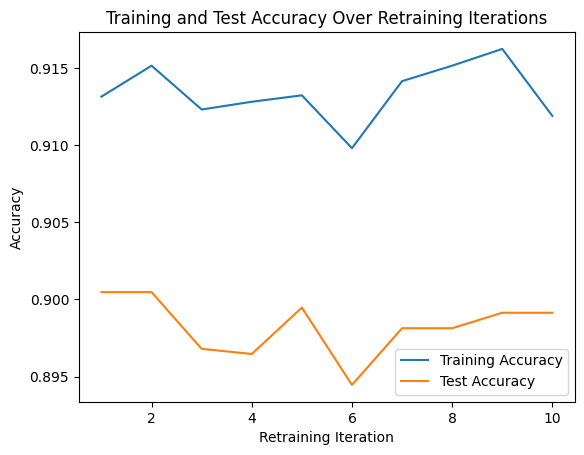

In [63]:
#εκκίνηση προσομοίωσης "λ" αρχιτεκτονικής με επανεκπαίδευση μοντέλου
simulate_streaming_lambda_architecture(csv_file_path, model, scaler, architecture_choice)